# Causal Data Science Week 5 Tutorial

In this tutorial we will practice how to learn a causal graph from constraint based structure learning with the PC algorithm. We will go through the algorithm both by-hand and with the CausalDiscoveryTool package.

## SGS and PC algorithm

The PC algorithm is a constraint based causal discovery algorithm named after its authors **P**eter Spirtes and **C**lark Glymour. The idea of this algorithm is based on conditional independence testing. 

For the simplicity of coding, we will start with a simpler version called SGS algorithm (https://www.researchgate.net/publication/242448131_Causation_Prediction_and_Search). SGS algorithm has the same input/output relations as the PC algorithm for faithful distributions. The SGS algorithm always considers all possible pairs of nodes in the graph while the PC algorithm considers only adjacent pairs of nodes. SGS has higher complexity since it has to run more conditional independence tests and it is also less reliable since the determination of higher order conditional independence relations is generally less reliable than the determination of lower order conditional independence relations.

The implementation below is a naive version of SGS algorithm, where we check the v-structures and direct edges by hands 

Assuming Markov and faithfulness, a CPDAG (completed partially directed acyclic graph) can be estimated. The algorithm process is as follows:
- Determine the skeleton
- Determine the v-structures
- Direct as many of the remaining edges as possible.


We go through an example with synthetic dataset. The example graph is taken from: https://stat.ethz.ch/lectures/ss21/causality.php#course_materials.

In [2]:
# import necessary packages
import warnings
warnings.filterwarnings('ignore')

import dowhy
from dowhy import CausalModel

import cdt
cdt.SETTINGS.rpath = '/usr/local/bin/Rscript' # for macOS
# cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.0.3/bin/Rscript' # for Windows

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from numpy.random import normal

from itertools import combinations

We first ceate a synthetic dataset that contains 5 variables with linear dependencies between them. Each noise term is drawn from a Gaussian distribution. We can use scatter plots to plot the relationship between any two variables.

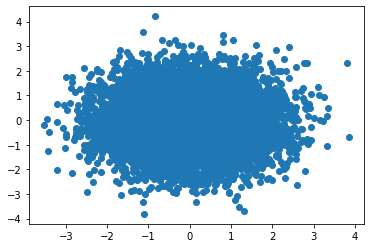

In [3]:
n_samples=10000

eps1 = normal(0, 1, n_samples)
eps2 = normal(0, 1, n_samples)
eps3 = normal(0, 0.7, n_samples)
eps4 = normal(0, 1.5, n_samples)
eps5 = normal(0, 1, n_samples)

x1 = eps1
x2 = eps2
x3 = x1 + x2 + eps3
x4 = 2 * x1 + eps4
x5 = 3 * x3 + eps5

# we can plot scatter plots between any two variables 
plt.scatter(x1, x2)

In [4]:
df = pd.DataFrame({'x1': x1,'x2': x2,'x3': x3,'x4': x4,'x5': x5})
df.head()

,x1,x2,x3,x4,x5
0,0.719425,-1.667034,-1.382579,1.086911,-3.597063
1,-0.390718,-0.264235,-0.481120,1.427620,-3.185071
2,0.953303,-0.670162,0.712237,2.800139,1.338302
3,0.508529,0.857927,1.165871,0.217565,2.778093
4,0.290840,1.553508,1.525368,0.953854,5.513868


From the data simulation, we know the true underlying graph, while normally we do not have access. The true causal graph is as follows:

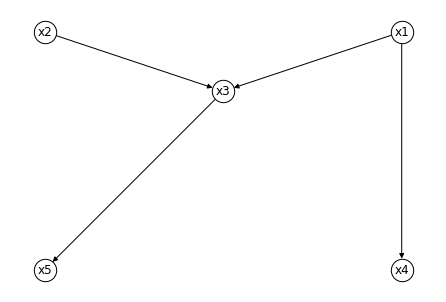

In [5]:
nodes = ["x1", "x2", "x3", "x4", "x5"]
pos = {'x2': (-1, 1),              'x1': (1, 1),
       'x3': (0, 0.5),          'x4': (1, -1), 
       'x5': (-1, -1),}

true_graph = nx.DiGraph()
true_graph.add_nodes_from(nodes)
true_graph.add_edges_from([('x1', 'x3'), ('x2', 'x3'), ('x1', 'x4'), ('x3', 'x5')])

nx.draw(true_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

### Determine the skeleton
The first step is to determine the skeleton. We start with the complete graph with the number of nodes $p$. Then for $k = 0,1,...,p-2$, consider all pairs of vertices $(i, j)$, and remove the edge between them if $X_i$ and $X_j$ are conditionally independent given some subset of size $k$ of $p\setminus(i, j)$.

We start with a fully connected undirected graph with number of nodes 5.

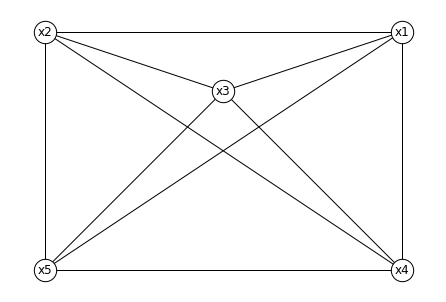

In [6]:
edges = combinations(nodes, 2)
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

nx.draw(G, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

In **round 1**, We use partial correlation that we introduced in Tutorial 2 to do conditional independence testing. For the first round we test independence between any pair of variables with a conditioning set with size of 0.

By default we use the significance level of 0.05. The Null hypothesis H0 is: $X \!\perp\!\!\!\perp Y$. The alternative hypothesis H1 is: $X \not \!\perp\!\!\!\perp Y$. 

,n,r,CI95%,p-val
pearson,10000,-0.001,"[-0.02, 0.02]",0.92


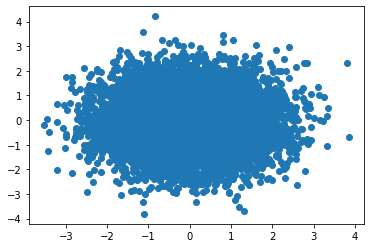

In [7]:
import pingouin as pg
alpha=0.05 # significance level

plt.scatter(x1, x2)
# you can also use R packages such as ppcor
pg.partial_corr(data=df, x='x1', y='x2', covar=[]).round(3) 

The non-significant p-value shows that we fail to reject H0 and therefore we remove the edge between x1 and x2. From the scatter plot we can also see that x1 and x2 are likely to be independent.

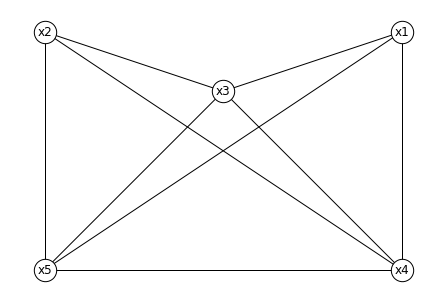

In [8]:
G.remove_edge('x1', 'x2')
nx.draw(G, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

,n,r,CI95%,p-val
pearson,10000,0.626,"[0.61, 0.64]",0.0


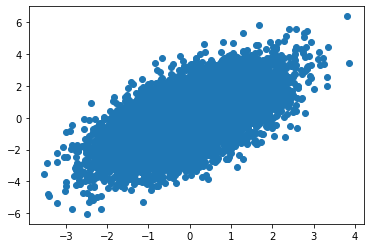

In [9]:
plt.scatter(x1, x3)

pg.partial_corr(data=df, x='x1', y='x3', covar=[]).round(3)

The p-value is smaller than 0.05 so we reject H0 and therefore the data favors $X1 \not \!\perp\!\!\!\perp X3$, and so we keep the edge between them. The plot also shows a correlation tendency.

We go through the whole edge list and remove the edges when two nodes are independent.

removing edge:  ('x1', 'x2')
removing edge:  ('x2', 'x4')


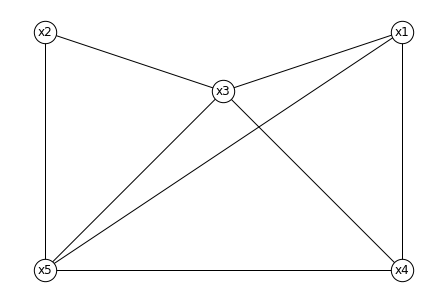

In [10]:
first_round_removed_edges = []
for (u, v) in combinations(nodes, 2):
    res = pg.partial_corr(data=df, x=u, y=v, covar=[]).round(3)
    p_val = res['p-val'].item()
    if p_val > alpha:
        first_round_removed_edges.append((u, v))
        print("removing edge: ", (u, v))
        # reject H0, indicating u and v are independent
        # we then remove the edge
        if G.has_edge(u, v): # safety check
            G.remove_edge(u, v)
nx.draw(G, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

Next in **round 2**, we have conditioning set of size one. Let's start with the set {x3}.

In [11]:
pg.partial_corr(data=df, x='x1', y='x5', covar=['x3']).round(3)

,n,r,CI95%,p-val
pearson,10000,-0.002,"[-0.02, 0.02]",0.849


The non-significant p-value shows that we fail to reject H0. We then remove the edge between x1 and x5.

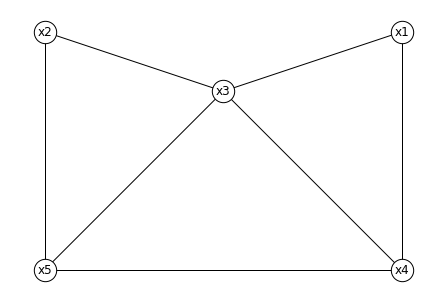

In [12]:
if G.has_edge('x1', 'x5'): # safety check
    G.remove_edge('x1', 'x5')
nx.draw(G, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

We go through all combinations of nodes with different conditioning sets and remove edges. 

removing edge:  ('x2', 'x4')
removing edge:  ('x3', 'x4')
removing edge:  ('x4', 'x5')
removing edge:  ('x1', 'x5')
removing edge:  ('x2', 'x5')
removing edge:  ('x4', 'x5')
removing edge:  ('x1', 'x2')


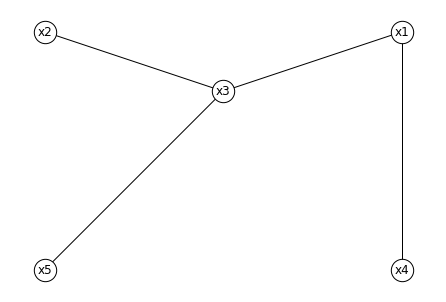

In [13]:
for z in nodes:
    for (x, y) in combinations([node for node in nodes if node != z], 2):
        res = pg.partial_corr(data=df, x=x, y=y, covar=[z]).round(3)
        p_val = res['p-val'].item()
        if p_val > alpha:
            print("removing edge: ", (x, y))
            # edge removal
            if G.has_edge(x, y): # safety check
                G.remove_edge(x, y)
                
nx.draw(G, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

We can continue performing the conditional independence testing with larger and larger conditioning sets. In this example, we don't have any other independences found. The full algorithm is below.

In [14]:
def sgs_algo(nodes, G, df, alpha=0.05):
    for size in range(len(nodes)-1):
        for z in combinations(nodes, size):
            for (x, y) in combinations([node for node in nodes if node not in z], 2):
                res = pg.partial_corr(data=df, x=x, y=y, covar=[z]).round(3)
                p_val = res['p-val'].item()
                if p_val > alpha:
                    print("removing edge: ", (x, y))
                    # edge removal
                    if G.has_edge(x, y): # safety check
                        G.remove_edge(x, y)
    return G

### Determine the v-structures

networkX does not support mixed graphs, so we convert the undirected graph to a directed graph. We use **black** edges to indicate directed edges and **red** bi-directional edges to indicate undirected edges.

Here we manully check the v-strucures. You can also implement an algorithm with Meek rules (http://proceedings.mlr.press/v89/katz19a/katz19a-supp.pdf) to find a complete orientation.

In [15]:
# utility function to transfer undirected graph to directed graph 
# with bi-directional edges with red-color to indicate undirected edges
def to_directed(H):
    D = nx.DiGraph()
    nodes = list(H.nodes())
    edges = []
    for (u, v) in H.edges():
        edges.append((u, v, {"directed": False}))
        edges.append((v, u, {"directed": False}))
    D.add_nodes_from(nodes)
    D.add_edges_from(edges)
    return D

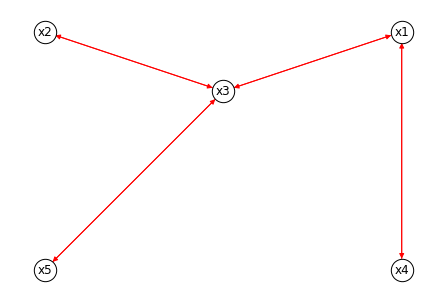

In [16]:
G_directed = to_directed(G)
colors = ['black' if G_directed[u][v]['directed']==True else 'r' for u,v in G_directed.edges()]
nx.draw(G_directed, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

From the first round we removed edges between x1 and x2, and between x2 and x4, so we know $X1 \!\perp\!\!\!\perp X2$. Because there is a node x3 that has undirected edges to x1 and x2, we can determine a v-structure for x2 -> x3 <- x1. 

In [17]:
first_round_removed_edges

[('x1', 'x2'), ('x2', 'x4')]

Based on the v-structure, we orient the directed edges (x2 -> x3) and (x1 -> x3).

In [18]:
def edge_removal(edges, G):
    for (x, y) in edges:
        if G.has_edge(x, y):
            G.remove_edge(x, y)
        nx.set_edge_attributes(G, {(y, x): {"directed": True}})
    colors = ['black' if G_directed[u][v]['directed']==True else 'r' for u,v in G_directed.edges()]
    return G, colors

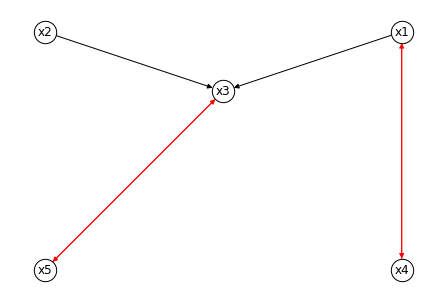

In [19]:
G_directed, colors = edge_removal([('x3', 'x2'), ('x3', 'x1')], G_directed)
nx.draw(G_directed, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

### Direct more edges if possible

Because there are no other v-structures, we know the edge direction (x5 -> x3) should not exist since it will bring additional v-structure. We thus orient the directed edge (x3 -> x5).

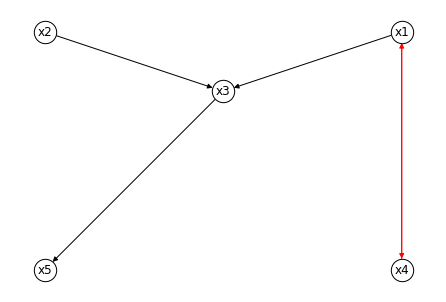

In [20]:
G_directed, colors = edge_removal([('x5', 'x3')], G_directed)
nx.draw(G_directed, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

We then run directly the PC algorithm from the CausalDiscoveryTool package and see the results. 
The default CItest we use here is Gaussion CI test. There is also a list of options possible for different CI tests.
```CI_test = {'binary': "pcalg::binCItest", 
             'discrete': "pcalg::disCItest",
             'hsic_gamma': "kpcalg::kernelCItest",
             'hsic_perm': "kpcalg::kernelCItest",
             'hsic_clust': "kpcalg::kernelCItest",
             'gaussian': "pcalg::gaussCItest",
             'rcit': "RCIT:::CItest",
             'rcot': "RCIT:::CItest"}```

In [21]:
def get_colors(G):
    edges = G.edges()
    for (x, y) in G.edges():
        if (y, x) in edges:
            # bi-directional edge
            nx.set_edge_attributes(G, {(x, y): {"directed": False}})
        else:
            nx.set_edge_attributes(G, {(x, y): {"directed": True}})
    colors = ['black' if G_directed[u][v]['directed']==True else 'r' for u,v in G_directed.edges()]
    return colors

In [22]:
model_pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)
created_graph = model_pc.create_graph_from_data(df)
colors = get_colors(created_graph)
nx.draw(created_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

R Call errored, is R available ?


FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/bin/Rscript'

The results from the PC algorithm match the result that we manually constructed. In general, the PC algorithm works well with the number of nodes smaller than 200. Also, the PC algorithm is sensitive to conditional independence tests and the number of samples.

The result is a Markov equivalence class that contains two valid DAGs. We are not able to orient the edge between x1 and x4 based on the conditional independence tests.

### Background knowledge

In many applications background knowledge of the causal system is available.
This information is typically of two kinds: Either it is known that a certain edge must or must not be present, or the orientation of a certain edge is known.

Within the PC() algorithm in CDT, we can provide a graph with prior knowledge as part of the input.

For the example above, if we have the knowledge that x4 cannot cause x1, then we are able to orient the edge and therefore obtain the DAG.

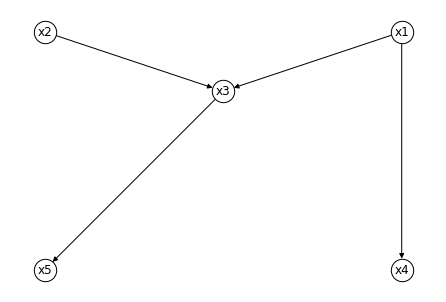

In [200]:
G_directed, colors = edge_removal([('x4', 'x1')], G_directed)
nx.draw(G_directed, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)
nx.write_gml(G_directed, "pc_graph.gml")

### Estimating in DoWhy

We can then use this graph in DoWhy and carry on causal effect estimation. Note that we can only use DAGs in DoWhy for the causal model. If the outputs from the PC algorithm are not DAGs then we are not able to use them directly in DoWhy.

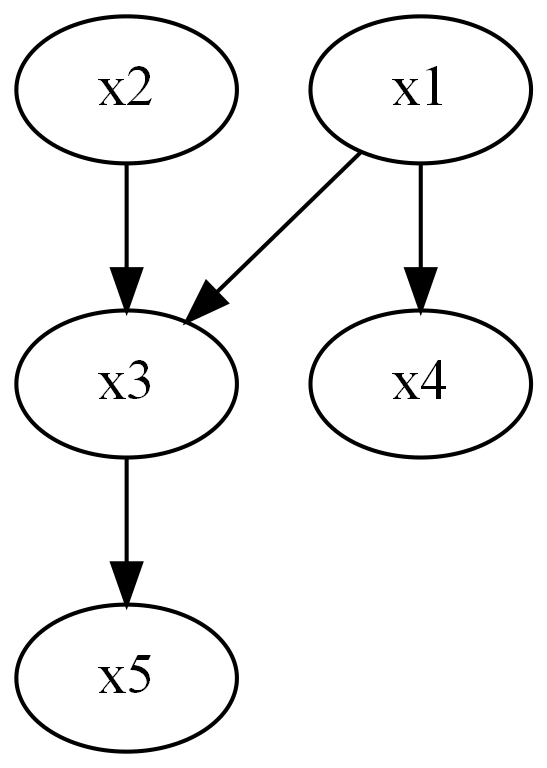

In [23]:
# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display

gml_graph = gml_to_string('pc_graph.gml')
# With GML string
model=CausalModel(
        data = df,
        treatment='x2',
        outcome='x5',
        graph=gml_graph
        )
model.view_model()

display(Image(filename="causal_model.png", width = 200, height = 100))

In [24]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                   
─────(Expectation(x5))
d[x₂]                 
Estimand assumption 1, Unconfoundedness: If U→{x2} and U→x5 then P(x5|x2,,U) = P(x5|x2,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(x5, [x3])*Derivative([x3], [x2]))
Estimand assumption 1, Full-mediation: x3 intercepts (blocks) all directed paths from x2 to x,5.
Estimand assumption 2, First-stage-unconfoundedness: If U→{x2} and U→{x3} then P(x3|x2,U) = P(x3|x2)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{x3} and U→x5 then P(x5|x3, x2, U) = P(x5|x3, x2)



In [25]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

Causal Estimate is 2.995533988443477
